# Evaluation

In [ ]:
!pip install xgboost
!pip install tabulate

In [1]:
import xgboost as xgb
from datetime import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.naive_bayes import ComplementNB
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Hyperparameters search

In [2]:
def tune_ovr_lr(clf, X_train, Y_train):
    start = datetime.now()
    params = {
        'estimator__penalty' : ['l2','l1'],
        'estimator__solver' : ['liblinear','newton-cholesky','saga'],  # default lbfgs
        'estimator__C': [0.01,0.1,1,5,10]   
    }
    lr_grid = GridSearchCV(clf, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs=-1)
    lr_grid.fit(X_train, Y_train)
    print("Time taken to perform hyperparameter tuning: ", datetime.now()-start)
    print("Tuned Hyperparameters :", lr_grid.best_params_)
    print("Best estimator: ", lr_grid.best_estimator_)
    print("Best Cross Validation Score: ", lr_grid.best_score_)
    return lr_grid.best_estimator_

In [3]:
def tune_rf(clf, X_train, Y_train):
    gs_start = datetime.now() 
    param_grid = { 
        'n_estimators': [5, 100],
        'max_depth' : [100,200, 250],
        'bootstrap' : [True, False],
        'class_weight': ['balanced', None],
        'min_samples_split' : [2,5]
    }
    gs_rf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1_micro')
    gs_rf.fit(X_train, Y_train)
    print("Time taken to perform grid search hyperparameter tuning: ",datetime.now()-gs_start)
    print("Tuned Hyperparameters :", gs_grid.best_params_)
    print("Best estimator: ", gs_rf.best_estimator_)
    print("Best Cross Validation Score: ",gs_rf.best_score_)
    return gs_rf.best_estimator_

In [4]:
def tune_ovr_xgb(clf, X_train, Y_train):
    gs_start = datetime.now() 
    param_grid = {
        'estimator__max_depth':[4,5,6],
        #'min_child_weight':[1,2],
        'estimator__learning_rate':[0.05, 0.1, 0.5],
        'estimator__gamma':[i/10.0 for i in range(0,5)],
        #'subsample':[0.5, 0.7],
        #'colsample_bytree':[0.5, 0.7]
    }
    model_tunning = GridSearchCV(clf, param_grid=param_grid, scoring ='f1_samples')
    model_tunning.fit(X_train, Y_train)
    print("Time taken to perform grid search hyperparameter tuning: ",datetime.now()-gs_start)
    print("Tuned Hyperparameters :", model_tuning.best_params_)
    print("Best estimator: ", model_tuning.best_estimator_)
    print("Best Cross Validation Score: ",model_tuning.best_score_)
    return model_tuning.best_estimator_

## Metrics computation

In [5]:
def compute_metrics(clf, X_test, Y_test, target_names):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    hamming_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay
    
    predictions = clf.predict(X_test)
    
    # confusion matrices
    f, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = axes.ravel()
    for i in range(Y_test.shape[1]):
        disp = ConfusionMatrixDisplay(confusion_matrix(Y_test[:, i], predictions[:, i]),
                                      display_labels=["no","yes"])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(f'{target_names[i]}')
        if i<10: disp.ax_.set_xlabel('')
        if i%5!=0: disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()
    plt.subplots_adjust(wspace=0.13, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()
    
    # scores
    acc = accuracy_score(Y_test, predictions)
    hl = hamming_loss(Y_test,predictions)
    prfs = []
    for avg in ['micro', 'macro', 'samples']:
        prec = precision_score(Y_test, predictions, average=avg, zero_division=0)
        rec = recall_score(Y_test, predictions, average=avg, zero_division=0)
        f1 = f1_score(Y_test, predictions, average=avg, zero_division=0)
        prfs.append((prec, rec, f1))
    
    # report
    print("\nClassification Report")
    print (classification_report(y_true = Y_test, y_pred = predictions, target_names = target_names, zero_division=0))
    return acc, hl, prfs

## Evaluate function

In [16]:
def evaluate(X_train, Y_train, X_test, Y_test, target_names):
    # defining the models
    ## OneVsRest + Complement Naive Bayes
    clf_ovr_cnb = OneVsRestClassifier(ComplementNB())
    ## OneVsRest + Logistic Regression
    clf_ovr_lr = OneVsRestClassifier(LogisticRegression(max_iter=100, n_jobs=-1))
    ## ClassifierChain + Logistic Regression
    clf_cc_lr = ClassifierChain(LogisticRegression(max_iter=100, n_jobs=-1),
                                order='random', random_state=2023)
    ## Random forest
    clf_rf = RandomForestClassifier(n_jobs = -1)
    # OneVsRest + XGBoost
    clf_ovr_xgb = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1))

    # hyperparameter tuning
    tuned_ovr_lr = tune_ovr_lr(clf_ovr_lr, X_train, Y_train)
    tuned_rf = tune_rf(clf_rf, X_train, Y_train)
    tuned_ovr_xgb = tune_ovr_xgb(clf_ovr_xgb, X_train, Y_train)
    
    # training the models
    clf_ovr_cnb.fit(X_train, Y_train)
    tuned_ovr_lr.fit(X_train, Y_train)
    clf_cc_lr.fit(X_train, Y_train)
    tuned_rf.fit(X_train, Y_train)
    tuned_ovr_xgb.fit(X_train, Y_train)
    
    # creating the list of models
    
    # getting the metrics
    models = [  ('OvR CNB', clf_ovr_cnb), ('OvR LR', tuned_ovr_lr), ('CC LR', clf_cc_lr), 
              ('RF', tuned_rf), ('OvR XGB', tuned_ovr_xgb) ]
    final_table = []
    for m in models:
        print(m[0])
        acc, hl, prfs = compute_metrics(m[1], X_test, Y_test, target_names)
        new_entry = [m[0], acc, hl]
        for prf in prfs:
            for met in prf: new_entry.append(met)
        final_table.append(new_entry)
    print(tabulate(final_table, headers=['model', 'acc', 'h_loss', 'prec_mic', 'rec_mic',
                                         'f1_mic', 'prec_mac', 'rec_mac', 'f1_mac', 'prec_sam',
                                         'rec_sam', 'f1_sam'], tablefmt='fancy_grid', floatfmt=".5f"))

## Example

### Data pre-processing

In [7]:
# Loading data
import ast
import pandas as pd

# reading the dataset 
df = pd.read_csv('../data/dataset_filtered_labels.csv')

# getting the list of genres 
genres = set()
for v in df['genres'].values: genres = set(list(genres) + ast.literal_eval(v))
genres = list(genres)

# creating the mappings from genres to id and vice versa
genre2id = {k:v for (v, k) in enumerate(genres)}
id2genre = {k:v for (k, v) in enumerate(genres)}

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df['summary'].to_numpy() # corpus - predictor variables
Y = np.full((X.shape[0], len(genres)), 0, dtype=int) # genres - target variables

# populating Y

genre_data = df['genres'].to_numpy() # genres assigned to works
for idx in range(len(Y)):
    genre_data[idx] = ast.literal_eval(genre_data[idx])
    for g in genre_data[idx]: Y[idx][genre2id[g]] = 1
        

# splitting dataset in train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=2023)

In [9]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# defining tokenizer which performs lemmatization and skips stop or/and non-alphabetic words
class LemmaTokenizer:
    def __init__(self):
        self.stops = set(stopwords.words('english'))
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t).lower() for t in word_tokenize(doc) if self.wnl.lemmatize(t) not in self.stops and t.isalpha()]
    
# defining TF-IDF vectorizer
# we put threshold of 1% for term presence in summaries so we can filter out the least common terms
# which can cause the overfitting of the classifier (this choice is backed by Zipf's law)
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.01)

In [10]:
X_train = vectorizer.fit_transform(X_train) # learning normalized TF-IDF weights
X_test = vectorizer.transform(X_test) # calculating TF-IDF weights


print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(8554, 2885) (2852, 2885)
(8554, 15) (2852, 15)


### Test

OvR CNB


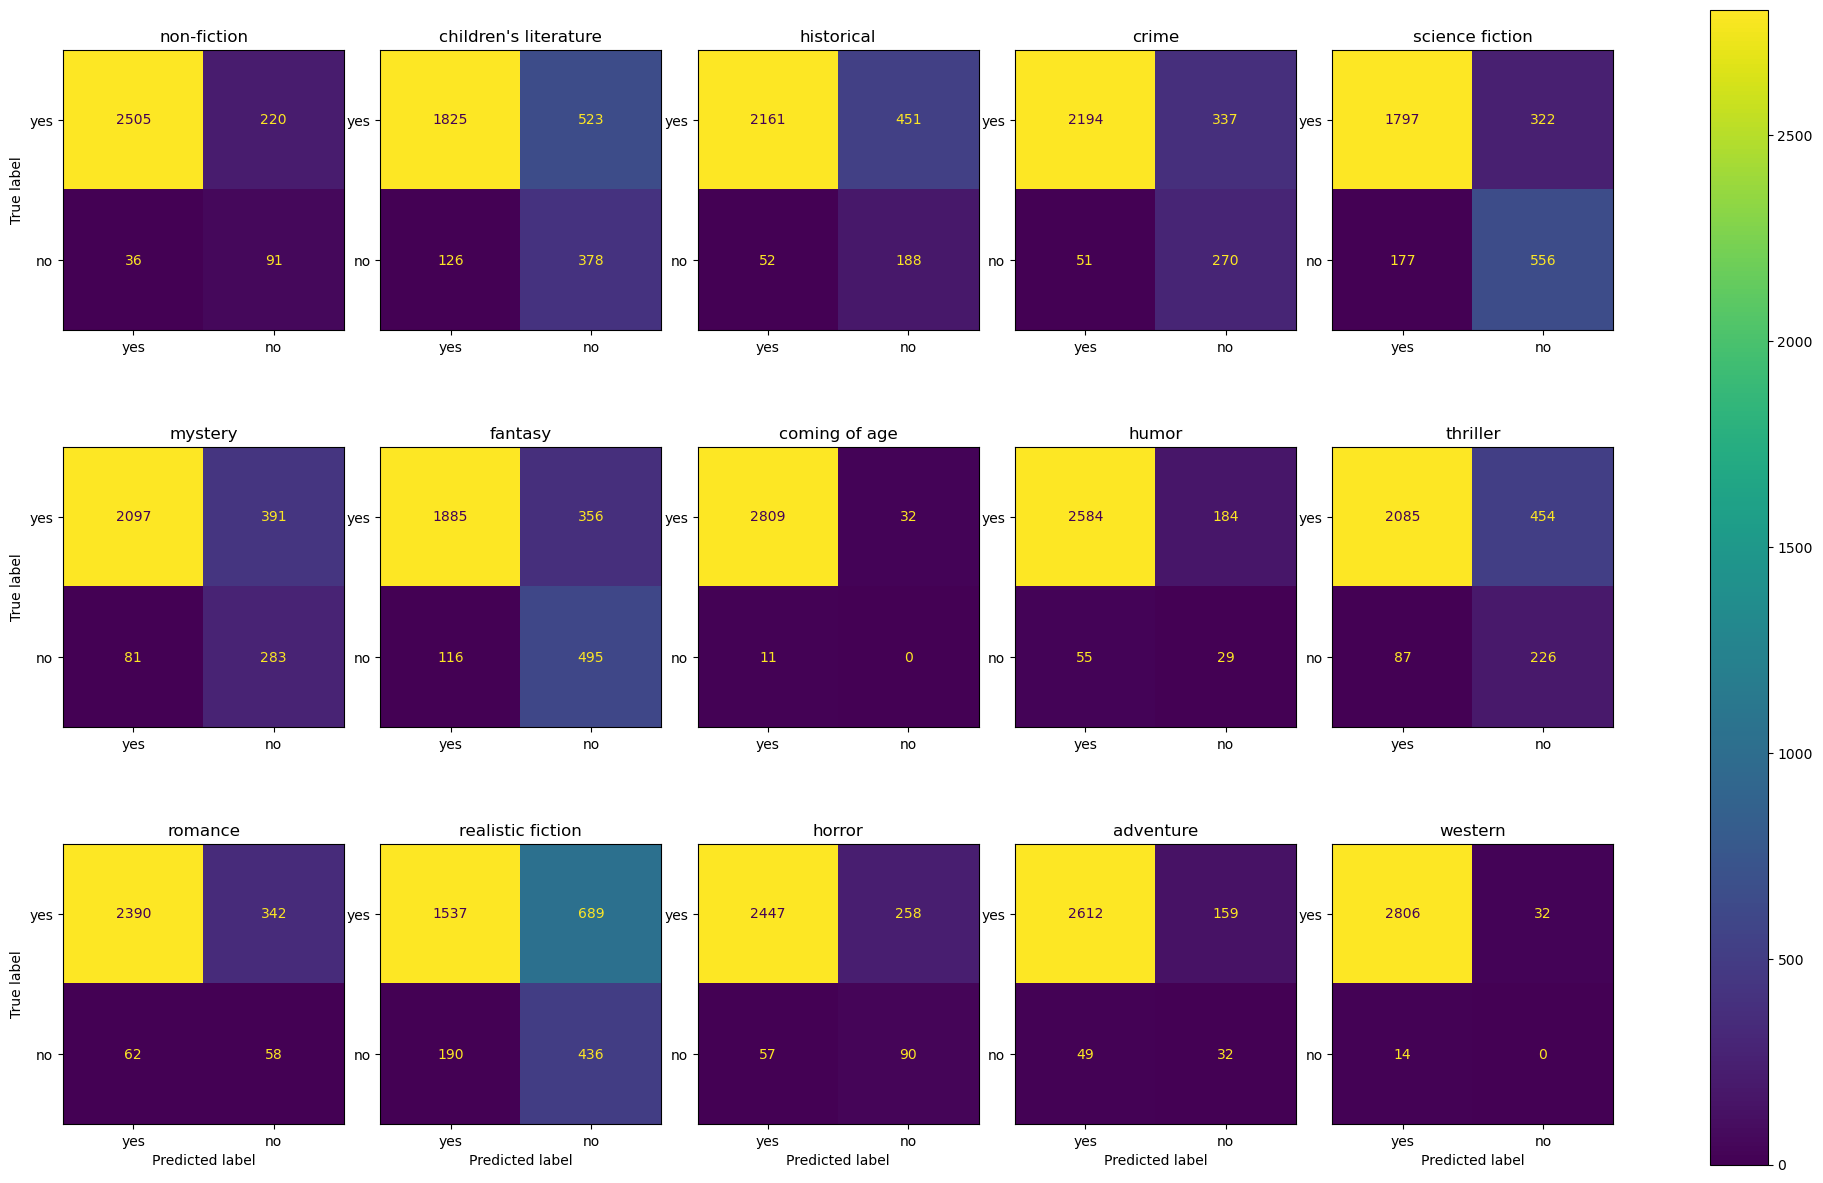


Classification Report
                       precision    recall  f1-score   support

          non-fiction       0.29      0.72      0.42       127
children's literature       0.42      0.75      0.54       504
           historical       0.29      0.78      0.43       240
                crime       0.44      0.84      0.58       321
      science fiction       0.63      0.76      0.69       733
              mystery       0.42      0.78      0.55       364
              fantasy       0.58      0.81      0.68       611
        coming of age       0.00      0.00      0.00        11
                humor       0.14      0.35      0.20        84
             thriller       0.33      0.72      0.46       313
              romance       0.14      0.48      0.22       120
    realistic fiction       0.39      0.70      0.50       626
               horror       0.26      0.61      0.36       147
            adventure       0.17      0.40      0.24        81
              western       0.0

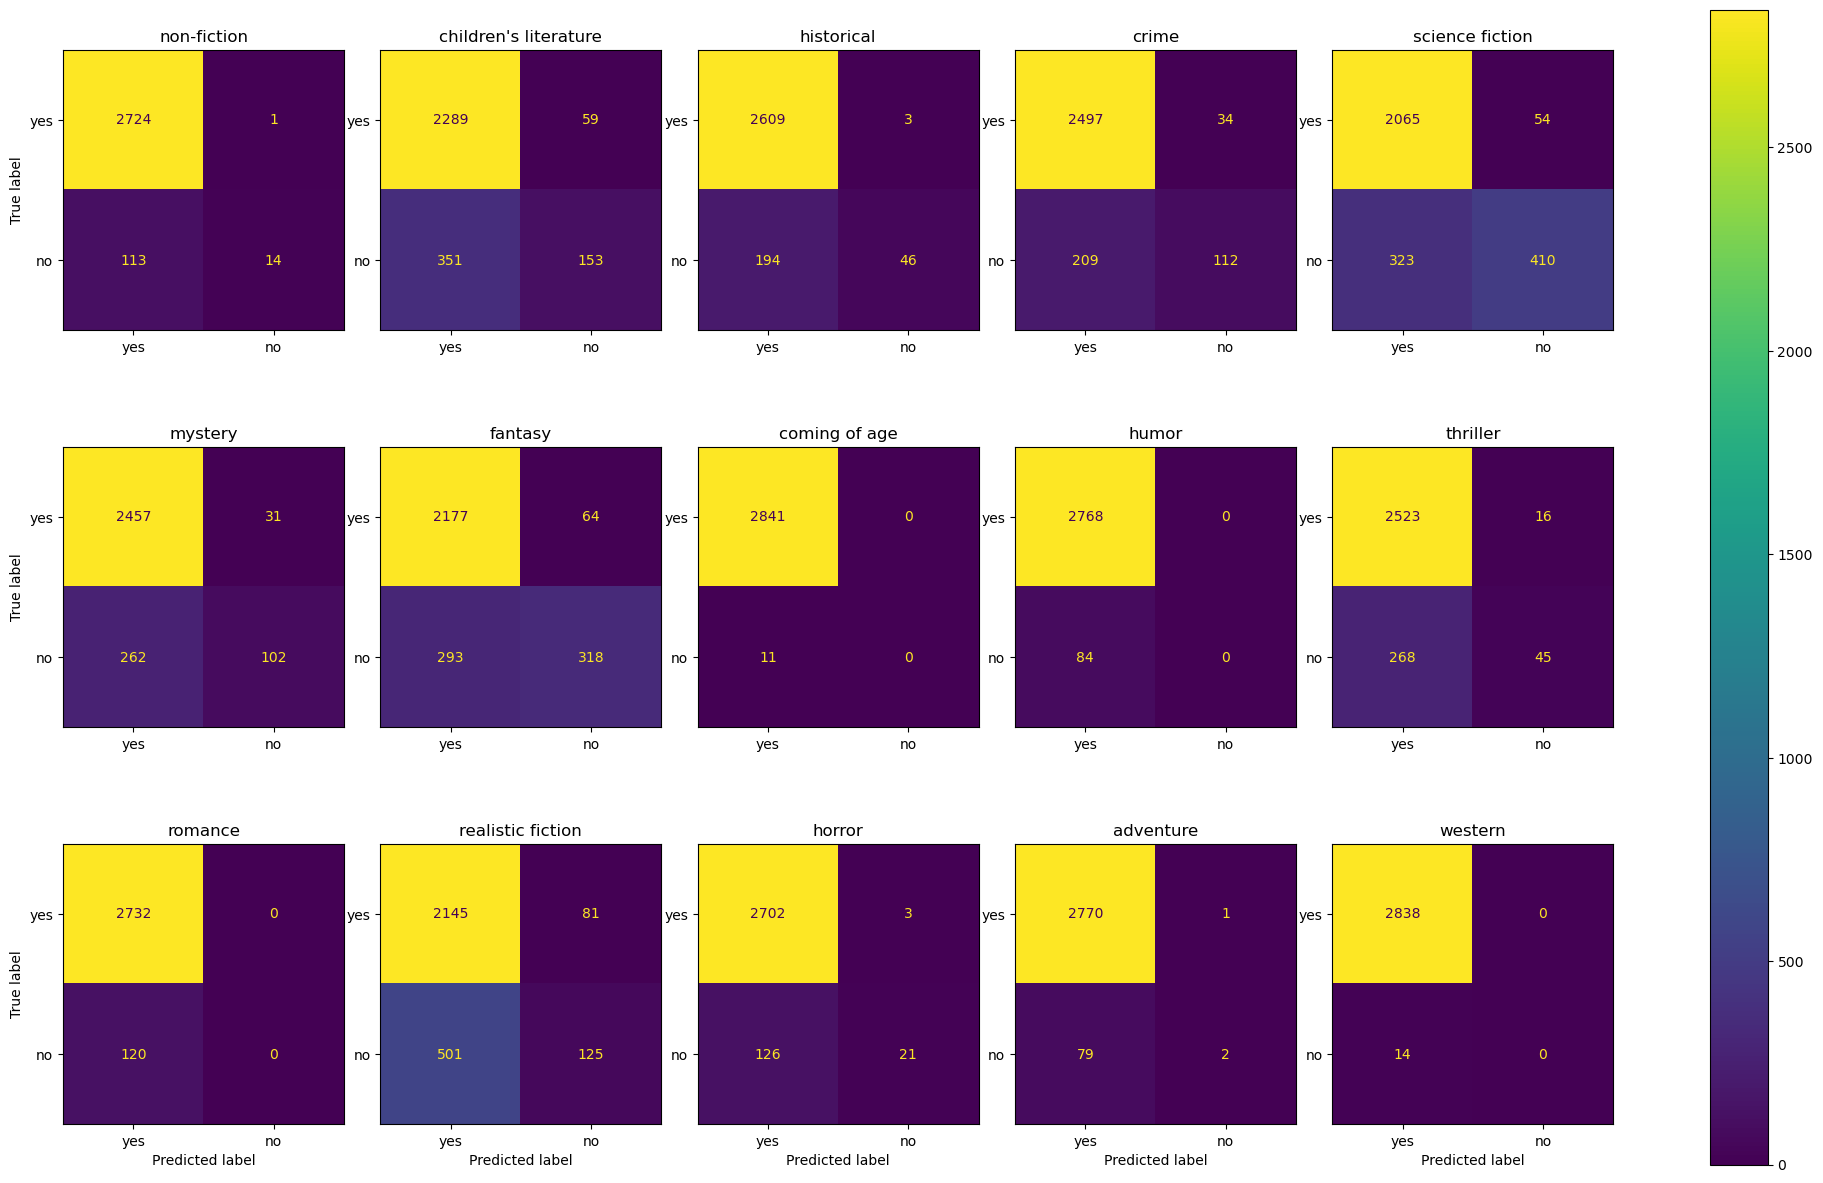


Classification Report
                       precision    recall  f1-score   support

          non-fiction       0.93      0.11      0.20       127
children's literature       0.72      0.30      0.43       504
           historical       0.94      0.19      0.32       240
                crime       0.77      0.35      0.48       321
      science fiction       0.88      0.56      0.69       733
              mystery       0.77      0.28      0.41       364
              fantasy       0.83      0.52      0.64       611
        coming of age       0.00      0.00      0.00        11
                humor       0.00      0.00      0.00        84
             thriller       0.74      0.14      0.24       313
              romance       0.00      0.00      0.00       120
    realistic fiction       0.61      0.20      0.30       626
               horror       0.88      0.14      0.25       147
            adventure       0.67      0.02      0.05        81
              western       0.0

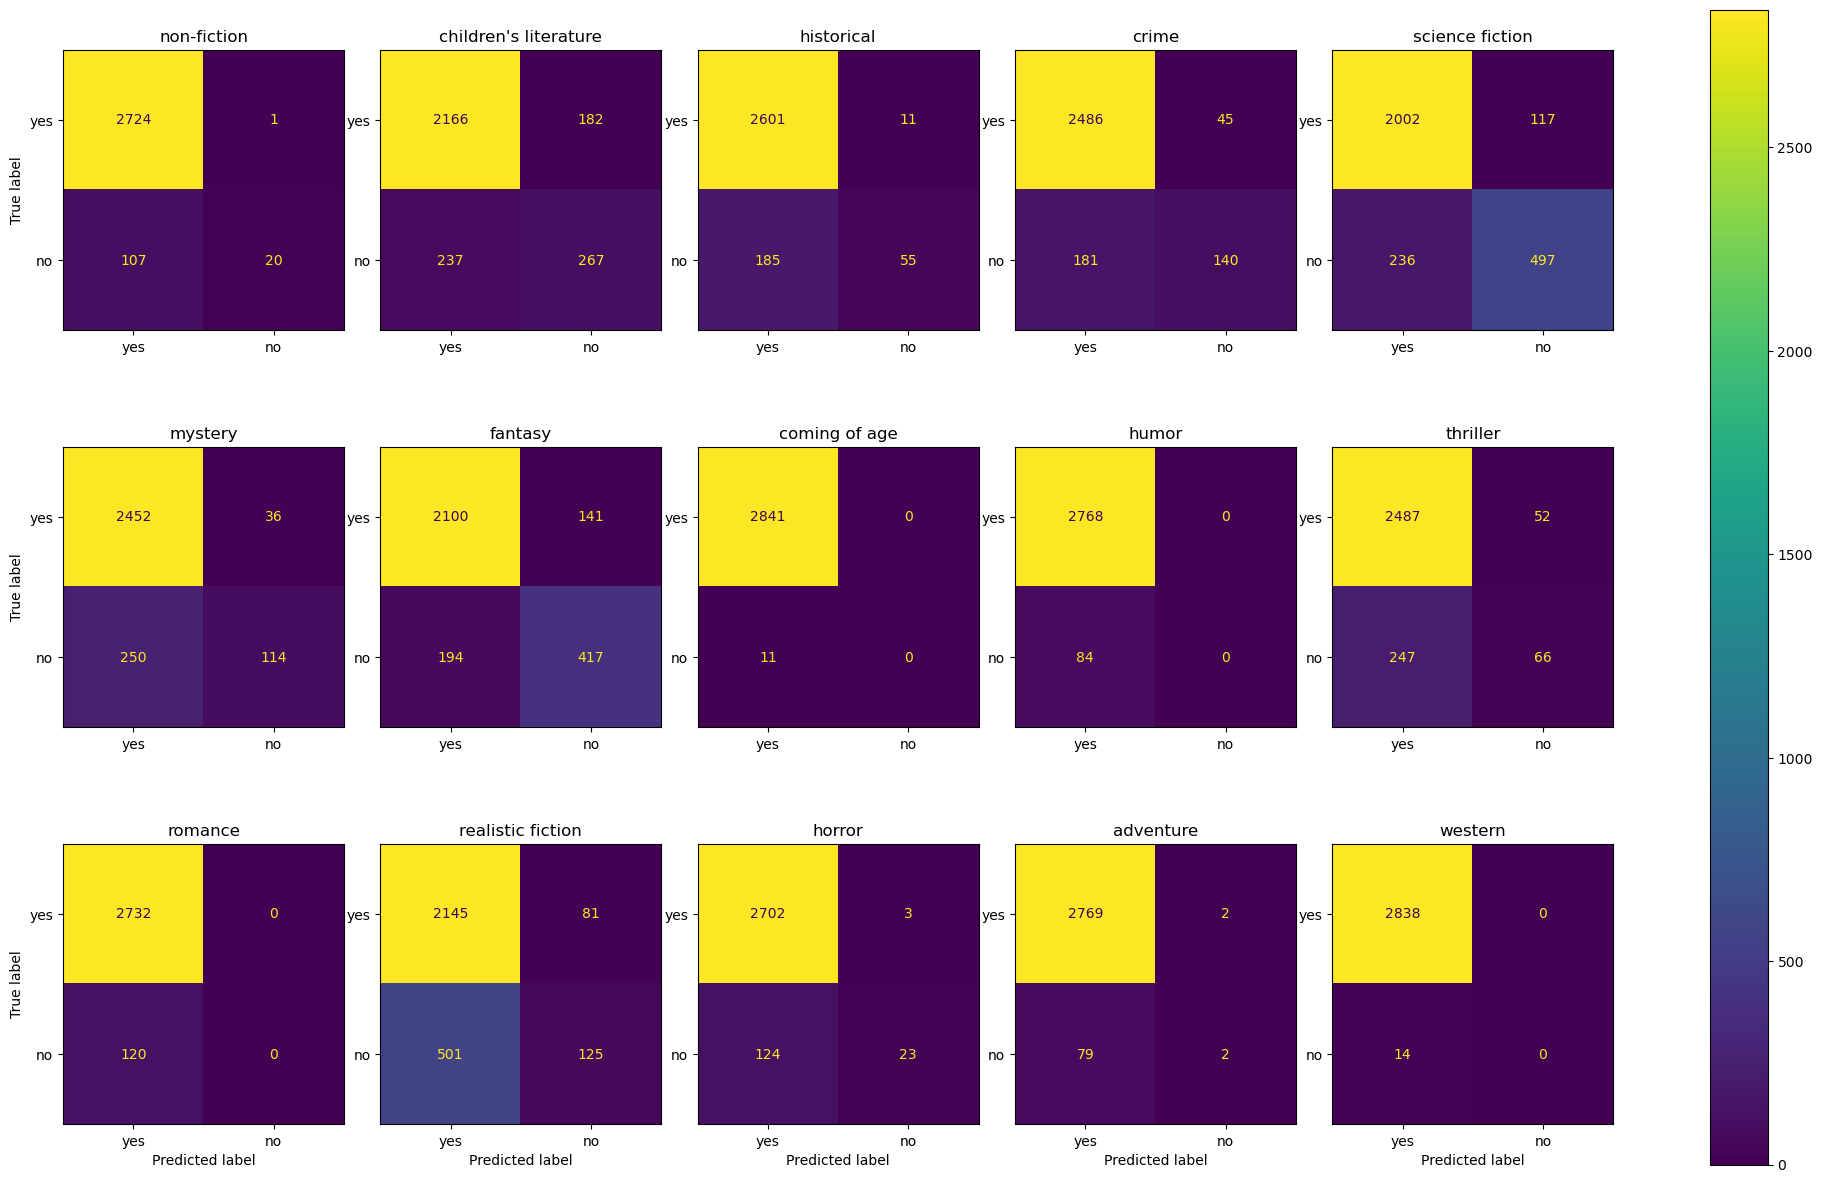


Classification Report
                       precision    recall  f1-score   support

          non-fiction       0.95      0.16      0.27       127
children's literature       0.59      0.53      0.56       504
           historical       0.83      0.23      0.36       240
                crime       0.76      0.44      0.55       321
      science fiction       0.81      0.68      0.74       733
              mystery       0.76      0.31      0.44       364
              fantasy       0.75      0.68      0.71       611
        coming of age       0.00      0.00      0.00        11
                humor       0.00      0.00      0.00        84
             thriller       0.56      0.21      0.31       313
              romance       0.00      0.00      0.00       120
    realistic fiction       0.61      0.20      0.30       626
               horror       0.88      0.16      0.27       147
            adventure       0.50      0.02      0.05        81
              western       0.0

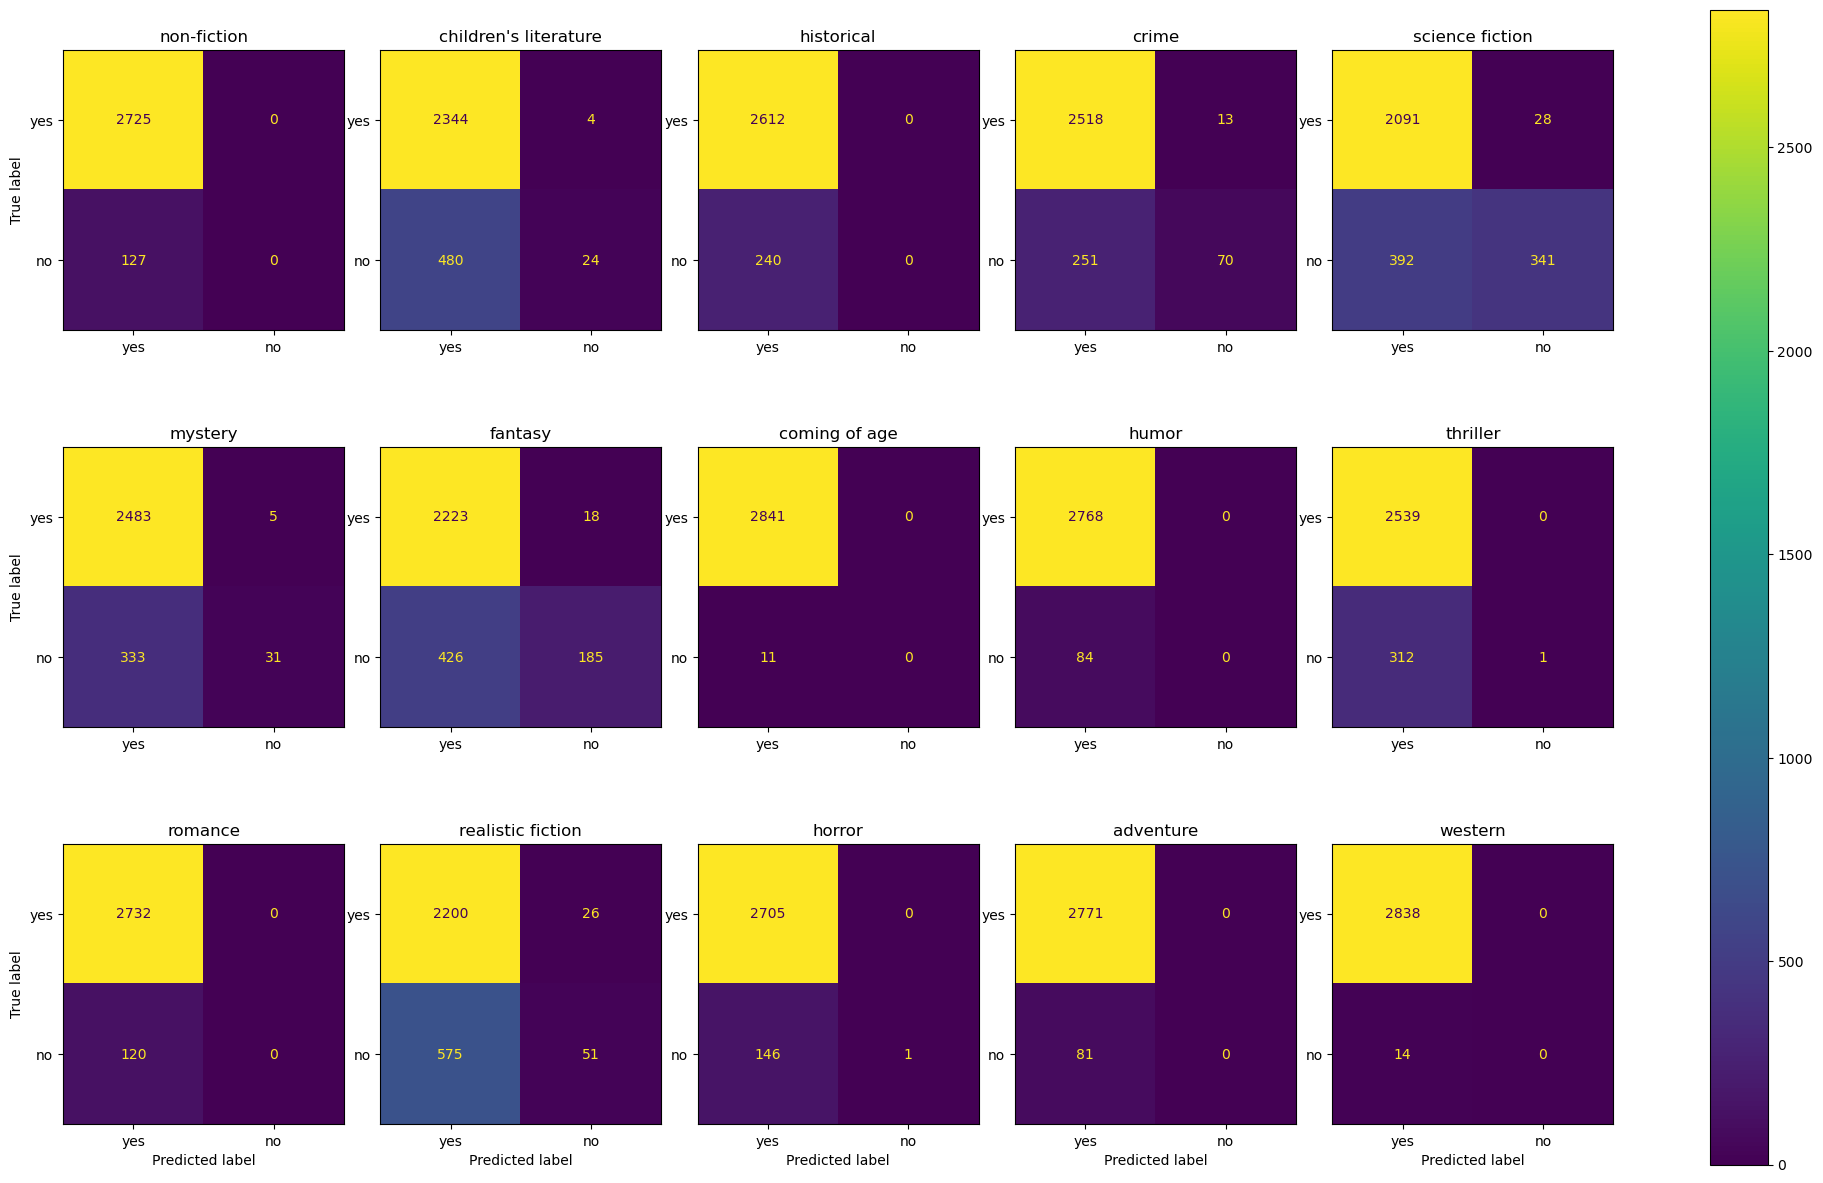


Classification Report
                       precision    recall  f1-score   support

          non-fiction       0.00      0.00      0.00       127
children's literature       0.86      0.05      0.09       504
           historical       0.00      0.00      0.00       240
                crime       0.84      0.22      0.35       321
      science fiction       0.92      0.47      0.62       733
              mystery       0.86      0.09      0.15       364
              fantasy       0.91      0.30      0.45       611
        coming of age       0.00      0.00      0.00        11
                humor       0.00      0.00      0.00        84
             thriller       1.00      0.00      0.01       313
              romance       0.00      0.00      0.00       120
    realistic fiction       0.66      0.08      0.15       626
               horror       1.00      0.01      0.01       147
            adventure       0.00      0.00      0.00        81
              western       0.0

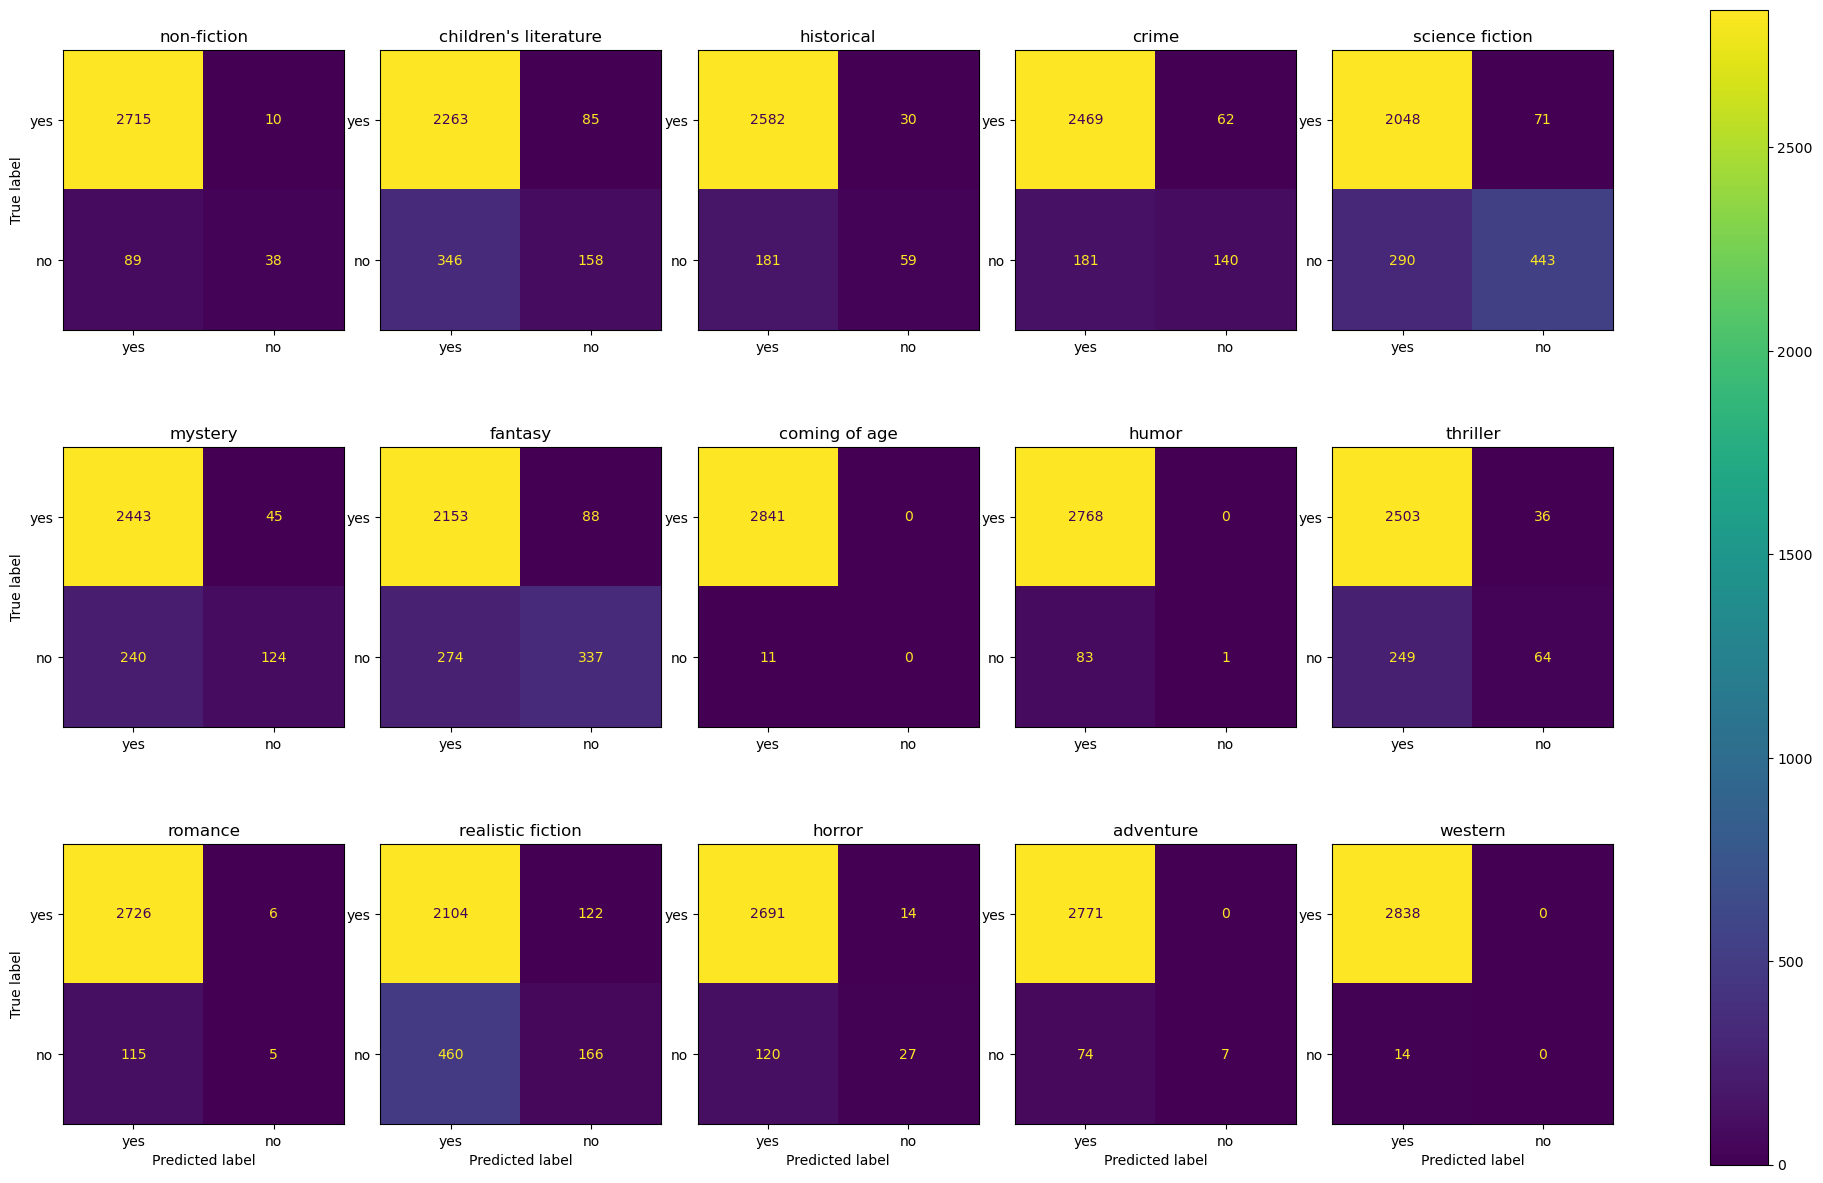


Classification Report
                       precision    recall  f1-score   support

          non-fiction       0.79      0.30      0.43       127
children's literature       0.65      0.31      0.42       504
           historical       0.66      0.25      0.36       240
                crime       0.69      0.44      0.54       321
      science fiction       0.86      0.60      0.71       733
              mystery       0.73      0.34      0.47       364
              fantasy       0.79      0.55      0.65       611
        coming of age       0.00      0.00      0.00        11
                humor       1.00      0.01      0.02        84
             thriller       0.64      0.20      0.31       313
              romance       0.45      0.04      0.08       120
    realistic fiction       0.58      0.27      0.36       626
               horror       0.66      0.18      0.29       147
            adventure       1.00      0.09      0.16        81
              western       0.0

In [17]:
evaluate(X_train, Y_train, X_test, Y_test, genres)